Sample: Myeloid_Basophils


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


Filtered out 28293 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 629 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:01)
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/28 cores)


  0%|          | 0/7267 [00:00<?, ?cells/s]

    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_arrows_Myeloid_Basophils.svg


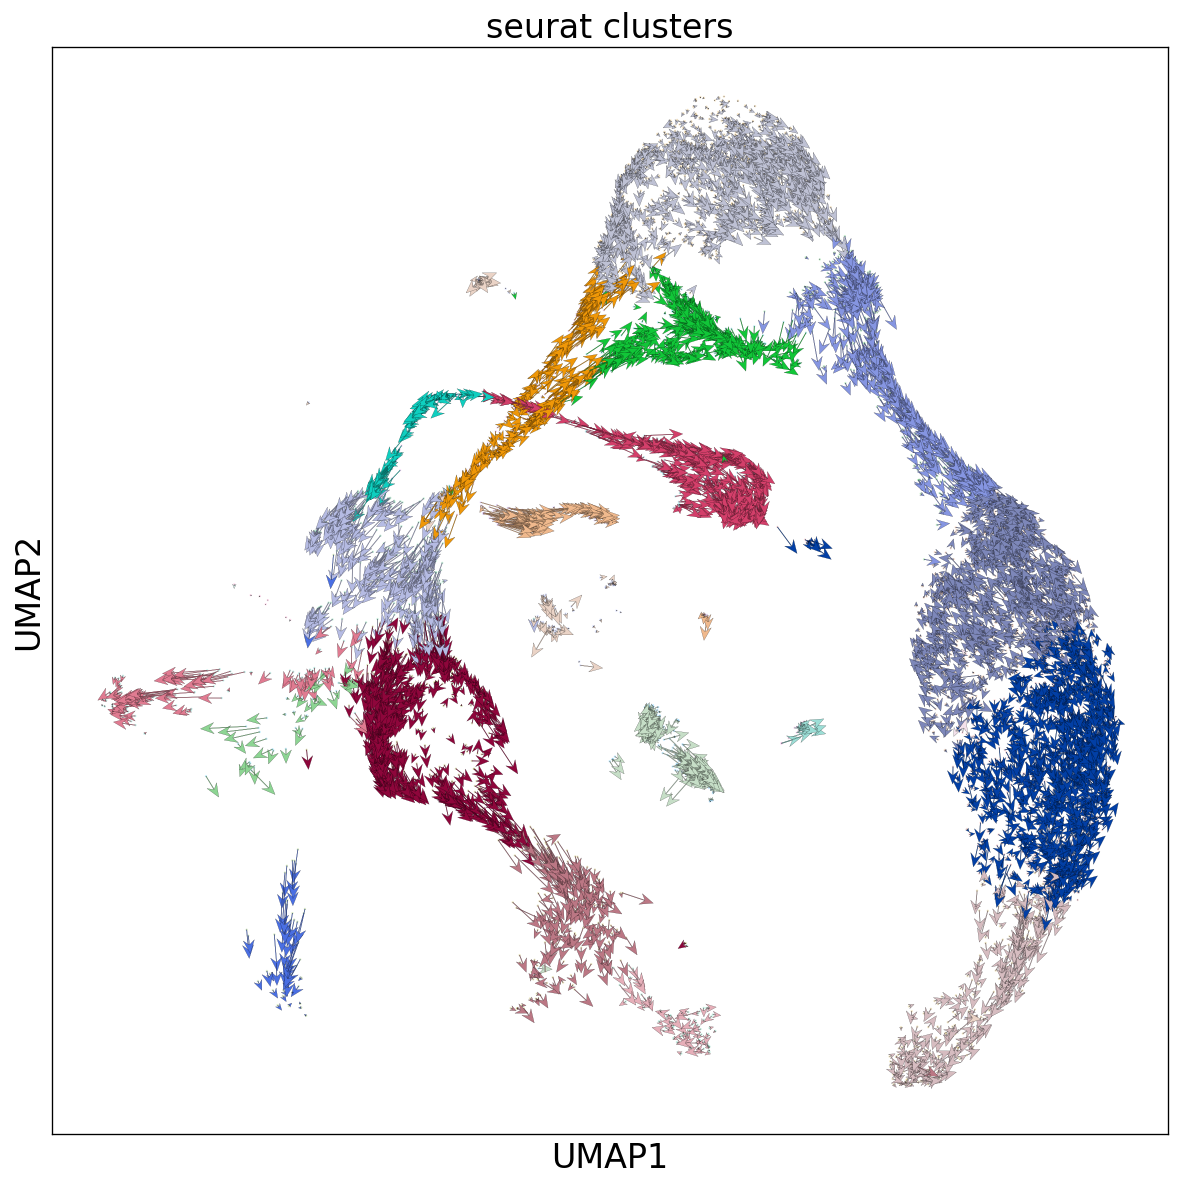

saving figure to file ./figures/scvelo_streamline_Myeloid_Basophils.svg


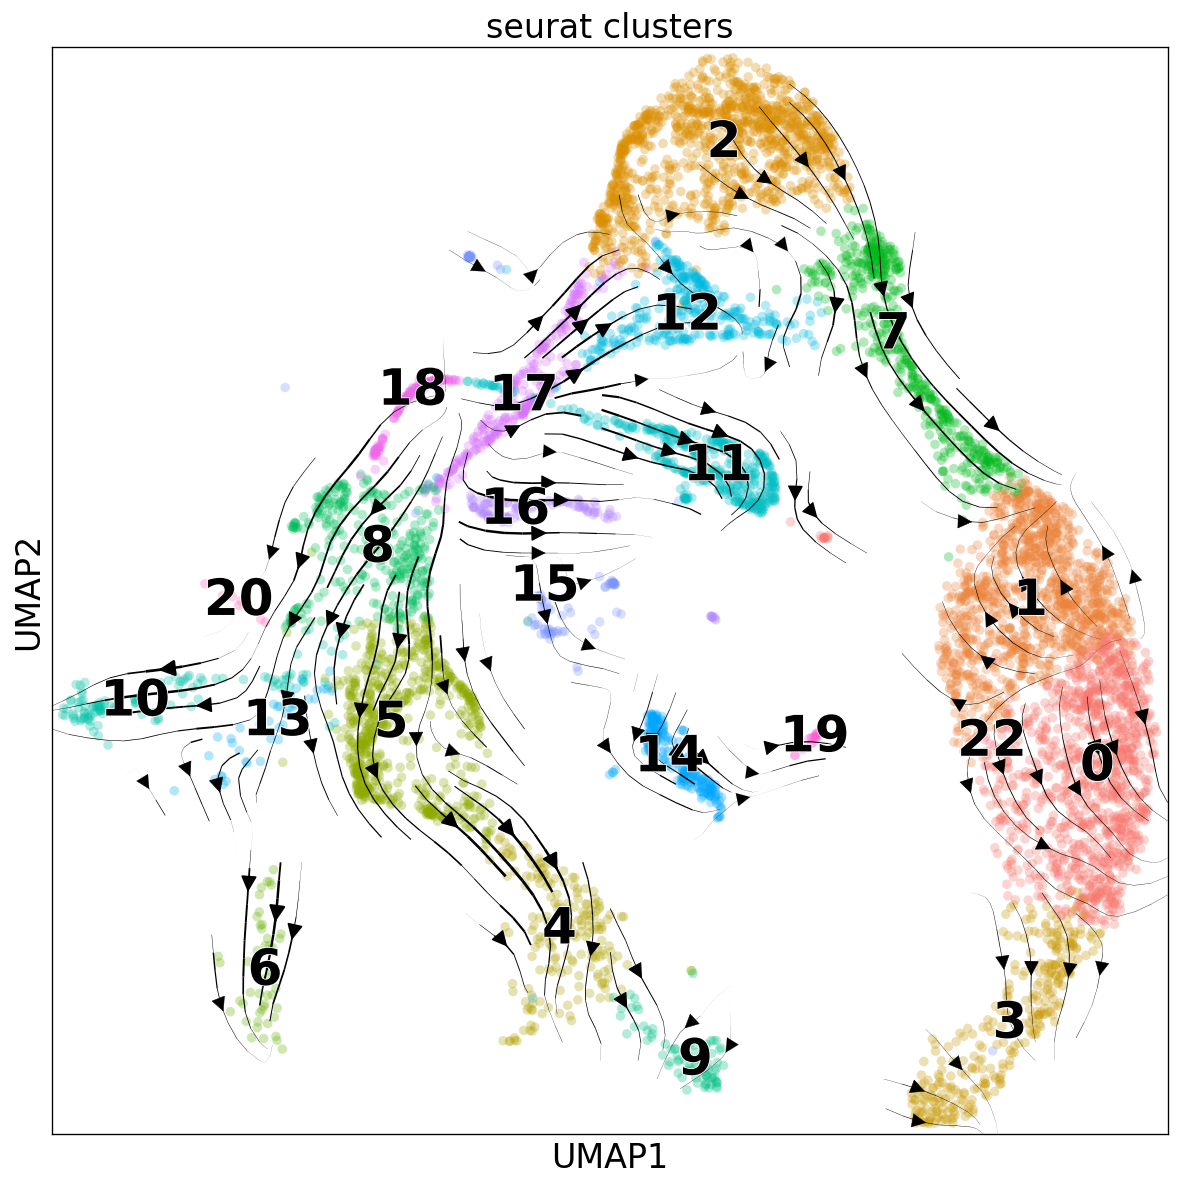

computing terminal states
    identified 4 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
saving figure to file ./figures/scvelo_pseudotime_Myeloid_Basophils.svg


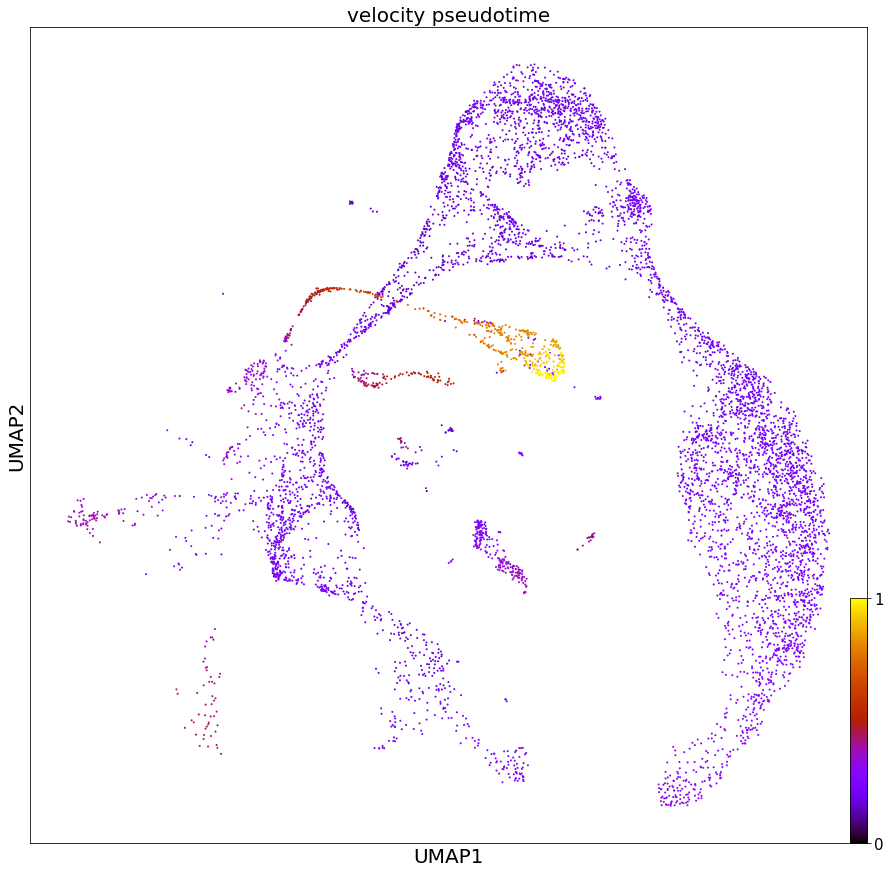

In [1]:
import scanpy as sc
import numpy as np
import os
import anndata2ri
import pathlib
import scvelo as scv
from scipy import io
import anndata#
import pandas as pd
from tqdm import tqdm
import argparse
import sys

# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
# sc.logging.print_versions()

import warnings
warnings.filterwarnings("ignore")

##### read loom data
path_to_loom_folder = "/home/hieunguyen/CRC1382/outdir/EStange_loom"

all_loom_files = [item for item in pathlib.Path(path_to_loom_folder).glob("*.loom")]

velo_data_dict = dict()
for path_to_loom_file in tqdm(all_loom_files):
    tmp_velo_data = scv.read_loom(path_to_loom_file)
    samplename = tmp_velo_data.obs.index[0].split(":")[0]
    new_obs = ["{}_{}_{}-1".format(samplename, 
                                   samplename, 
                                   item.split(":")[1].replace("x", "")) for item in tmp_velo_data.obs.index]
    tmp_velo_data.obs.index = new_obs
    tmp_velo_data.obs["barcode"] = new_obs
    tmp_velo_data.var_names_make_unique()
    velo_data_dict[samplename] = tmp_velo_data
    
velo_data = velo_data_dict[list(velo_data_dict.keys())[0]]

for key in tqdm(list(velo_data_dict.keys())[1:]):
    velo_data = velo_data.concatenate(velo_data_dict[key])

new_obs = ["-".join(item.split("-")[0:2]) for item in velo_data.obs.index]
velo_data.obs.index = new_obs  

##### read adata
sample1 = "d4_LPS"
sample2 = "d4_SPF"

path_to_src = "/home/hieunguyen/CRC1382/src/src_pipeline/scRNA_GEX_pipeline/processes_src"

outdir = "/home/hieunguyen/CRC1382/outdir"
PROJECT = "EStange_20240411_SeuratV4_reduced_RNAcontam_0"
# sub_cluster_id = "Myeloid_Basophils"
s_obj_name = "all_sobj.integrated.rds"

path_to_main_output = os.path.join(outdir, PROJECT, "data_analysis")
for sub_cluster_id in ["full", "Myeloid_Basophils", "T_cells", "B_cells"]:
    path_to_01_output = os.path.join(path_to_main_output, "01_output")
    path_to_02_output = os.path.join(path_to_main_output, "02_output")
    path_to_03_output = os.path.join(path_to_main_output, "03_output")
    path_to_04_output = os.path.join(path_to_main_output, "04_output")
    path_to_05_output = os.path.join(path_to_main_output, "05_output", sub_cluster_id)
    path_to_seurat2anndata = os.path.join(path_to_main_output, "seurat2anndata")

    adata = sc.read_h5ad(os.path.join(path_to_seurat2anndata, '{}.h5ad'.format(sub_cluster_id)))

    print("Sample: {}".format(sub_cluster_id))




    ##### main processing part for RNA velocity
    colorfile = os.path.join("/home/hieunguyen/CRC1382/outdir/EStange_20240411_SeuratV4_reduced_RNAcontam_0/colors", sub_cluster_id, "colordf.csv")
    colors = pd.read_csv(colorfile)["color"].to_list()
    
    merge_data = scv.utils.merge(adata, velo_data)

    scv.pp.filter_genes(merge_data, min_shared_counts=20)
    scv.pp.normalize_per_cell(merge_data)
    scv.pp.filter_genes_dispersion(merge_data, n_top_genes=2000)
    scv.pp.log1p(merge_data)

    scv.pp.filter_and_normalize(merge_data, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(merge_data, n_pcs=30, n_neighbors=30)

    ##### Running RNA velocity inference
    scv.tl.velocity(merge_data)
    scv.tl.velocity_graph(merge_data)

    ##### arrows velocity
    scv.pl.velocity_embedding(merge_data, dpi=120, arrow_size=2, arrow_length=10, basis = "X_umap",color="seurat_clusters",
                            figsize = (12, 12), fontsize=20, legend_fontsize=40, frameon=True, palette = colors, save="arrows_{}.svg".format(sub_cluster_id))

    ##### streamline velocity plot
    scv.pl.velocity_embedding_stream(merge_data, dpi=120, arrow_size=2, basis = "X_umap",color="seurat_clusters",
                            figsize = (12, 12), fontsize=20, legend_fontsize = 30, frameon=True, palette = colors, save="streamline_{}.svg".format(sub_cluster_id))

    ##### pseuotime plot
    scv.tl.velocity_pseudotime(merge_data)
    scv.pl.scatter(merge_data, color='velocity_pseudotime', cmap='gnuplot', basis = "X_umap",
                    figsize = (15, 15), fontsize=20, legend_fontsize = 30, frameon=True, save="pseudotime_{}.svg".format(sub_cluster_id))